In [ ]:
import os
import spacy
import string
import tqdm
import csv
from gensim.models import Word2Vec
import gensim
from collections import defaultdict
import math
import pandas as pd
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import tempfile
import seaborn as sns
from scipy.spatial.distance import cosine
from wordfreq import top_n_list
from wordcloud import WordCloud
from functions import preprocess_text
from functions import tfidf
from functions import get_decade
from functions import get_mapping
from functions import similar_words_df
from functions import semantic_drift_time
from functions import get_interval
from functions import make_intervals
from functions import projected_vector
from functions import extract_years
from fucntions import get_period_from_model

We load the spacy spanish dictionary and we had to extend the max length because some laws are too long

In [4]:
nlp = spacy.load("es_core_news_sm")
nlp.max_length = 2000000

We make a loop, where we input every law into the preprocessing function, and we store the results in a list

In [ ]:
files = os.listdir('./input/')[1:]
data = []
for file in tqdm.tqdm(files):
    filepath = './input/' + file
    match = re.search(r'Ley (\d+)_texto_(\d+)', file)
    if match:
        ley_numero = match.group(1)  
        año = match.group(2)

        with open(filepath, 'r', encoding='utf-8') as text_file:
            file_content = text_file.read()
            clean_content = preprocess_text(file_content, True, False)

        data.append((ley_numero, año, clean_content))
        
with open('./input/clean_data.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

100%|██████████| 7381/7381 [36:23<00:00,  3.38it/s]  


To avoid cleaning the data every time, we store it

Again, since some laws are very long, we have to extend the limits for the csv module

In [18]:
csv.field_size_limit(10_000_000)
clean_data = []
with open('./input/clean_data.csv', 'r', encoding='utf-8', newline='') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        row[2] = ast.literal_eval(row[2])
        clean_data.append(row)

We make a bar plot with the amount of laws per decade

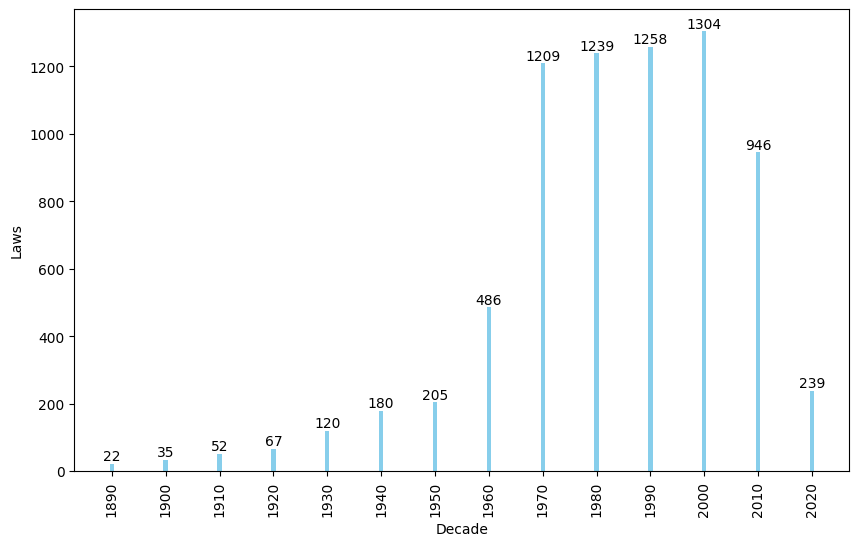

In [ ]:
decades, counts = np.unique([get_decade(int(year)) for _, year, _ in clean_data], return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(decades, counts, width=0.8, color='skyblue') 
plt.xticks(decades, rotation=90)

for i, count in enumerate(counts):
    plt.text(decades[i], count+0.5, str(count), ha='center', va='bottom')

plt.xlabel('Decade')
plt.ylabel('Number of Laws')

plt.savefig('./output/laws_for_decade.png')

plt.show()

As we can see, the amount of laws per decade are very unbalanced, this is probably due to the fact that the earlier on they were written, the less likely it is that they have been digitalized. We will have to make some decisions on how to balance these numbers for the analysis.

We decided to randomly select 50 laws from each decade, however, since between 1890 and 1910 we don't have 50 laws per decade, we grouped both decades into a single interval and selected 50 laws from that extended period

We keep track of the laws in each interval in order for us to randomly select 50 laws per decade and keep our observations balanced

In [ ]:
laws_by_decade = defaultdict(list)
for law, year, words in clean_data:
    year = int(year)
    if year < 1910:
        decade = "1890-1910"
    else:
        decade_start = get_decade(year)
        decade = f"{decade_start}-{decade_start + 9}"
    laws_by_decade[decade].append((law, year, words))
    
random.seed(111)
selected_laws = []
for decade, laws in laws_by_decade.items():
    selected_laws.extend(random.sample(laws, 50))
    
with open('./input/selected_laws.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(selected_laws)

In [3]:
csv.field_size_limit(10_000_000)
selected_laws = []
with open('./input/selected_laws.csv', 'r', encoding='utf-8', newline='') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        row[2] = ast.literal_eval(row[2])
        selected_laws.append(row)

Now, for each interval, we calculate the tfidf vectors, considering each year inside the interval as a single document, and we identify for each year the top 10 "most important" words, which will be the words with the highest tfidf value inside that year. Since there are probably some errors within our preprocessing and also with the transcription of the laws, some typos made their way into these "most important" words and therefore, we decided to only include words with more than 4 characters. This way, we avoid missed transcriptions

In [6]:
intervals = make_intervals()
top_words = {}
for interval in intervals:
    interval = [str(num) for num in interval]
    tfidf_vectors, vocab_index = tfidf(selected_laws, interval=interval)
    tfidf_vectors = pd.DataFrame(tfidf_vectors, index=vocab_index.keys())
    tfidf_vectors = tfidf_vectors[tfidf_vectors.index.str.len() > 4]
    
    top_words_per_year = {}
    for year in tfidf_vectors.columns:
        sorted_words = tfidf_vectors[year].sort_values(ascending=False)
        top = sorted_words.head(10)
        top_words_per_year[year] = top.index.tolist()
    
    top_words[f"{interval[0]}-{interval[-1]}"] = pd.DataFrame.from_dict(
        top_words_per_year, orient='index', 
        columns=[f"Top {i+1}" for i in range(10)]
    )
top_words = pd.concat(top_words, axis=0)
top_words.to_csv('./input/palabras_importantes.csv')

Now, we count the amount of times each "most important" word has appeared across all years, to identify those that are the most frequent. We do this in order to restrict our analysis to the "most important" words across the entire time period studied

In [7]:
all_words = top_words.values.flatten()
all_words = [word for word in all_words if pd.notnull(word)]
word_counts = Counter(all_words)
ranking_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
ranking_df = ranking_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
ranking_df.to_csv('./input/palabras_mas_recurrentes.csv', index= False)

## Word2Vec

We now compute the Word2Vec models across each interval, so first, we transform our data in order for it to be compatible with the Word2Vec function, creating a list that encompasses all the words for every law within each interval

In [ ]:
intervals = make_intervals()
words_by_interval = defaultdict(list)
for interval in intervals:
    start_year = interval[0]
    end_year = interval[-1]
    
    for element in selected_laws:
        _, year, words = element 
        year = int(year)
        if start_year <= year <= end_year:
            words_by_interval[f"{start_year}_{end_year}"].append(words)

We compute every Word2Vec model

In [28]:
for interval, words in tqdm.tqdm(words_by_interval.items()):
    globals()[f"model_{interval}"] = Word2Vec(words, vector_size= 300, window= 5, workers= 5) 

100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


In [29]:
for interval, _ in tqdm.tqdm(words_by_interval.items()):
    model = globals()[f'model_{interval}']
    with tempfile.NamedTemporaryFile(prefix= f'gensim-model-{interval}', delete=False) as tmp:
        model.save(f'./word2vec_models/gensim-model-{interval}')

100%|██████████| 13/13 [00:00<00:00, 158.63it/s]


## Analysis

Now that we have our models, we can begin our analysis

We load the Word2Vec models prevously stored

In [2]:
intervals = make_intervals()
for interval in intervals:
    start = interval[0]
    end = interval[-1]
    model_file = os.path.join('./word2vec_models/', f'gensim-model-{start}_{end}')
    try:
        os.path.exists(model_file)
        globals()[f'model_{start}_{end}'] = gensim.models.Word2Vec.load(model_file)
    except Exception as e:
        print(e)

## Most similar Words

In [3]:
ranking_df = pd.read_csv('./input/palabras_mas_recurrentes.csv')
top_words = pd.read_csv('./input/palabras_importantes.csv')
top_words.columns = ['decada', 'año'] + list(top_words.columns[2:])

We identify in which models whould we look for these most recurrent words, since they are not likely to be in every model

In [4]:
results = []
for word in ranking_df['Word']:
    years_found = top_words[top_words.iloc[:, 2:].isin([word]).any(axis=1)]['año'].tolist()
    results.append({'word': word, 'years': years_found})

words_years = pd.DataFrame(results)

models_to_use = defaultdict(set)
for _, row in words_years.head(5).iterrows():
    word = row.iloc[0]
    years = row.iloc[1]
    for interval in intervals:
        for year in years:
            if year in interval:
                models_to_use[word].add(f'model_{interval[0]}_{interval[-1]}')
                
models_to_use = {word: list(models) for word, models in models_to_use.items()}

In [5]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_map = {}


def color_func(word, *args, **kwargs):
    return color_map.get(word, "black")

def plot_wordcloud(word, models_to_use, name, top_n=10):
    global color_map
    color_map = {}
    words_dict = {}
    legend_elements = []
    model_names = models_to_use[word]
    
    for idx, model_var in enumerate(model_names):
        try:
            model = globals()[model_var]
            if word not in model.wv:
                print(f"'{word}' not found in the vocabulary of model '{model_var}'. Skipping.")
                continue
            
            similar_words = model.wv.most_similar(word, topn=top_n)
            
            model_color = colors[idx % len(colors)]
            model_label = re.search(r'model_(\d+_\d+)', model_var)
            if model_label:
                label = model_label.group(1)
            else:
                label = model_var 

            legend_elements.append(plt.Line2D([0], [0], color=model_color, lw=4, label=label))
            
            for sim_word, similarity in similar_words:
                if len(sim_word) > 4:
                    words_dict[sim_word] = max(words_dict.get(sim_word, 0), similarity * 100)
                    color_map[sim_word] = model_color
                else:
                    continue
                
        except KeyError:
            print(f"Model '{model_var}' not found in globals(). Skipping.")
    
    words_dict[word] = 150
    color_map[word] = "black"
    
    wc = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1.0)
    wc.generate_from_frequencies(words_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc.recolor(color_func=color_func, random_state=3), interpolation="bilinear")
    plt.axis("off")
    
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Models", fontsize=10)
    plt.subplots_adjust(right=0.85)
    plt.savefig(f'./output/wordcloud_{name}.png')
    plt.show()

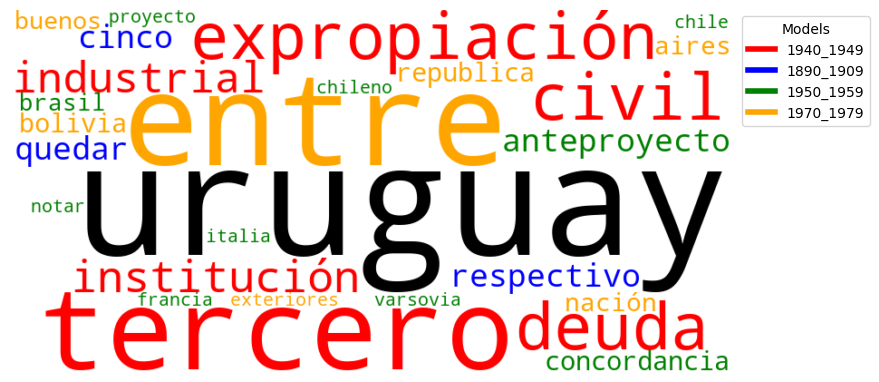

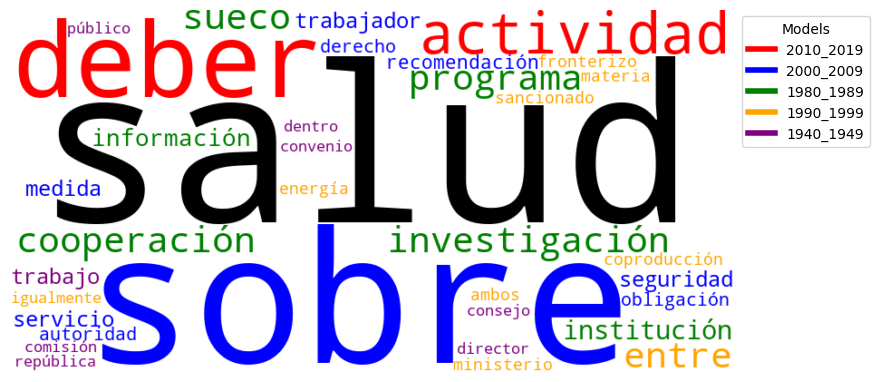

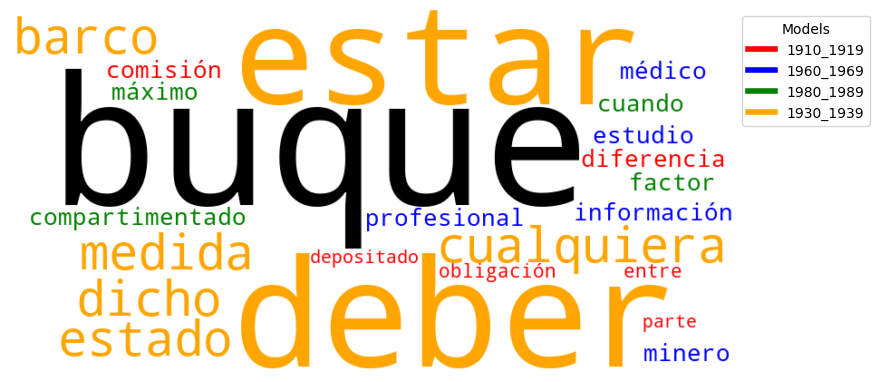

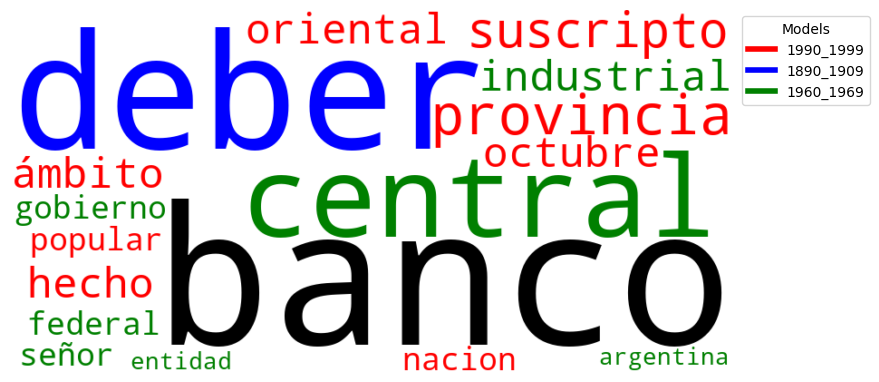

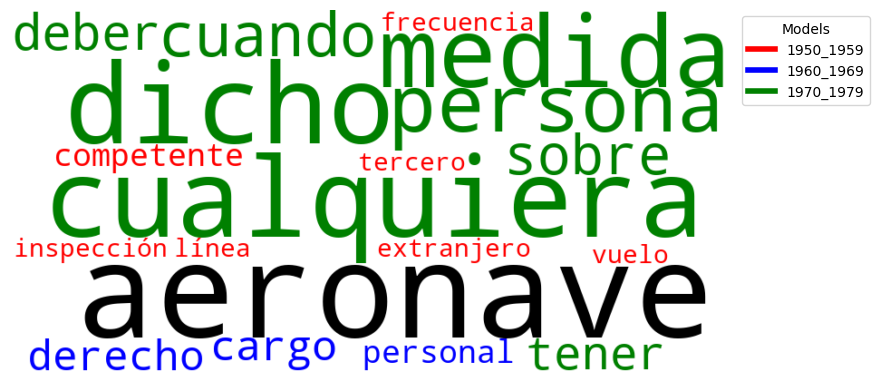

In [6]:
for word in models_to_use.keys():
    plot_wordcloud(word, models_to_use, word, 10)

We look through our models and store the most similar words to our most recurrent words

We create a list of every model we have in order for us to iterate over it

In [7]:
models = []
for interval in intervals:
    models.append(f"model_{interval[0]}_{interval[-1]}")

We want to know how many words in common does every model has with the 1890-1909 model, since this is the model we're gonna be projecting into the others, in order for us to get a sense of the semantic drift across time

In [8]:
for model in models[1:]:
    model = globals()[model]
    mapping = get_mapping(model_1890_1909, model)
    print(len(mapping))

132
139
142
138
142
137
134
141
139
136
106
137


In [9]:
words = list(top_words.iloc[0:14, 2:].values.flatten())

We project the 1890-1909 into the space of every other model and store our results

In [10]:
proj = []
semantic_drift = []
for model_name in models[1:]:
    model = globals()[model_name]
    projected_words, drift_data = similar_words_df(model_1890_1909, model, words= words)
    
    for entry in projected_words:
        proj.append({
            "target_model": model_name,
            "word": entry["word"],
            "similar_word": entry["similar_word"],
            "score": entry["score"]
        })
        
    for drift_entry in drift_data:
        semantic_drift.append({
            "target_model": model_name,
            "word": drift_entry["word"],
            "semantic_drift": drift_entry["semantic_drift"]
        })

proj = pd.DataFrame(proj)
semantic_drift = pd.DataFrame(semantic_drift)

In [11]:
proj.to_excel('./output/projection.xlsx', index = False)
semantic_drift.to_excel('./output/semantic_drift.xlsx', index = False)
semantic_drift['target_model'] = semantic_drift['target_model'].str.extract(r'model_(\d+_\d+)')
semantic_drift['target_model'] = semantic_drift['target_model'].str.replace('_', '-', regex=False)

We identify every "top word" that at some point in time had the most semantic drift

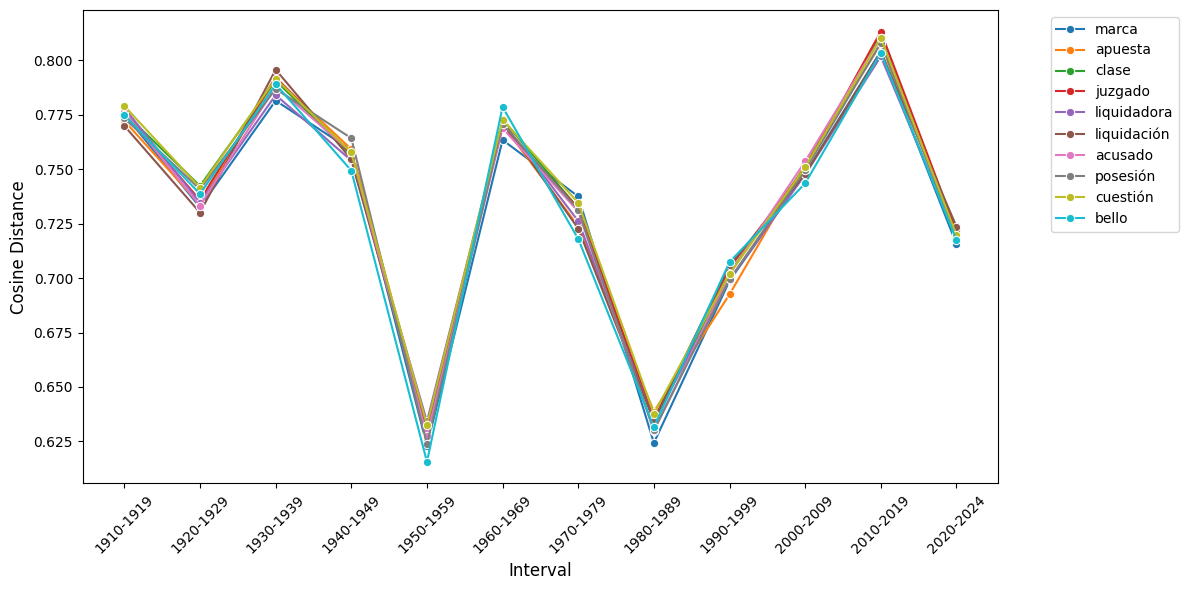

In [12]:
max_words = semantic_drift.loc[semantic_drift.groupby('target_model')['semantic_drift'].idxmax(), 'word']
selected_words = max_words.unique()
filtered_data = semantic_drift[semantic_drift['word'].isin(selected_words)]
semantic_drift_time(filtered_data, 'maximos')

We do the same but with every word that at some point had the least semantic drift

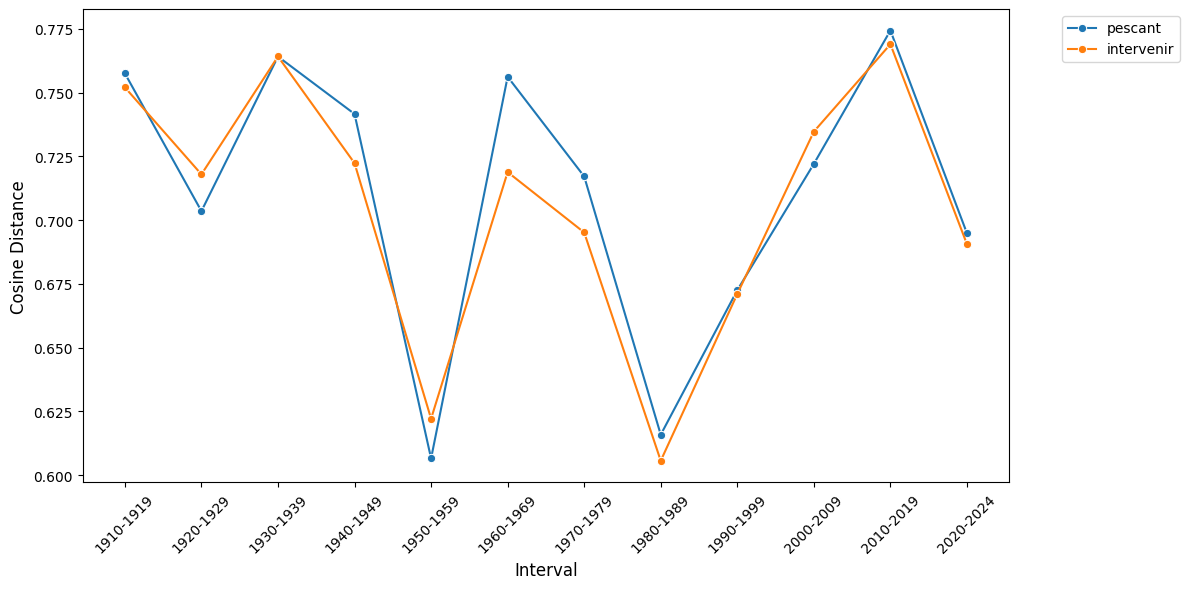

In [13]:
min_words = semantic_drift.loc[semantic_drift.groupby('target_model')['semantic_drift'].idxmin(), 'word']
selected_words = min_words.unique()
filtered_data = semantic_drift[semantic_drift['word'].isin(selected_words)]
semantic_drift_time(filtered_data, 'minimos')

In [14]:
drift = defaultdict(lambda: defaultdict(float))
for word, models in models_to_use.items():
    if word in model_1890_1909.wv:
        for model in models:
            if model != 'model_1890_1909':
                modelo = globals()[model]
                f = projected_vector(model_1890_1909, modelo, word)
                v = modelo.wv[word]
                distance = cosine(v, f)
                drift[word][model] = distance
                  
drift = pd.DataFrame(drift)

<Figure size 1200x600 with 0 Axes>

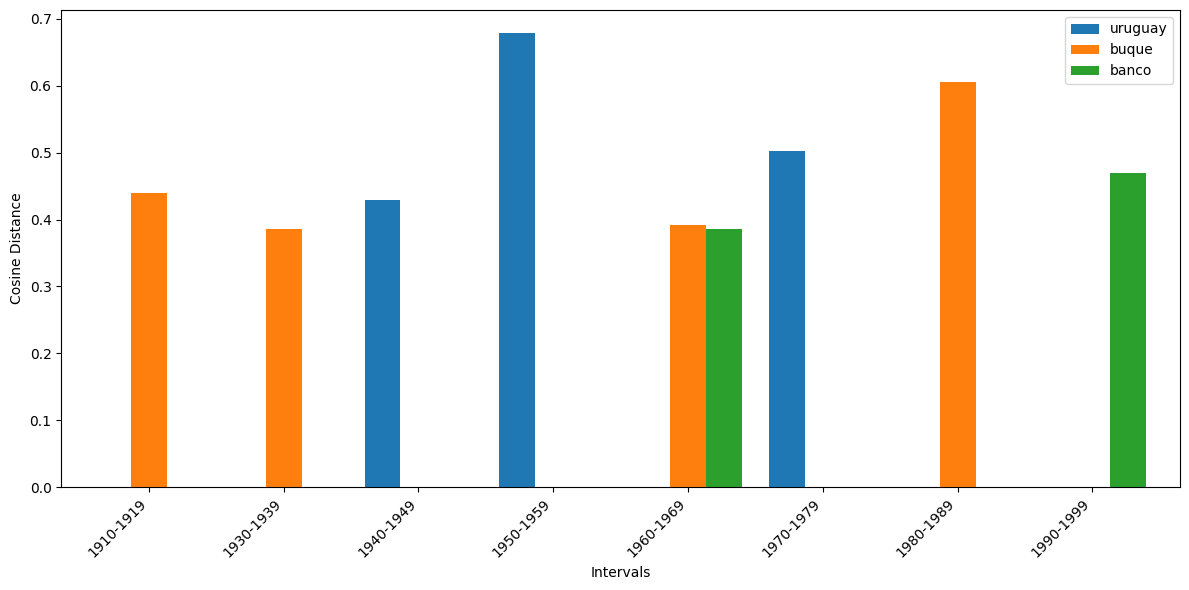

In [15]:
drift['year_range'] = drift.index.map(extract_years) 
drift['year_start'] = drift['year_range'].map(lambda x: int(x.split('-')[0]) if '-' in x else float('inf'))
drift_sorted = drift.sort_values(by='year_start').drop(columns=['year_start'])  

plt.figure(figsize=(12, 6))
ax = drift_sorted.drop(columns='year_range').plot(kind='bar', figsize=(12, 6), width=0.8)
ax.set_xlabel('Intervals')
ax.set_ylabel('Cosine Distance')
ax.set_xticklabels(drift_sorted['year_range'], rotation=45, ha='right')  
plt.tight_layout()
plt.savefig('./output/cosine_drift.png')
plt.show()

# Case Study

In [16]:
intervals = {
    'Agroexportador': list(range(1890, 1931, 1)),
    'ISI': list(range(1931, 1958, 1)),
    'Desarrollismo': list(range(1958, 1976, 1)),
    'Dictadura': list(range(1976, 1983, 1)),
    'Democracia': list(range(1983, 2000, 1)),
    'SXXI': list(range(2000, 2025, 1))
    }

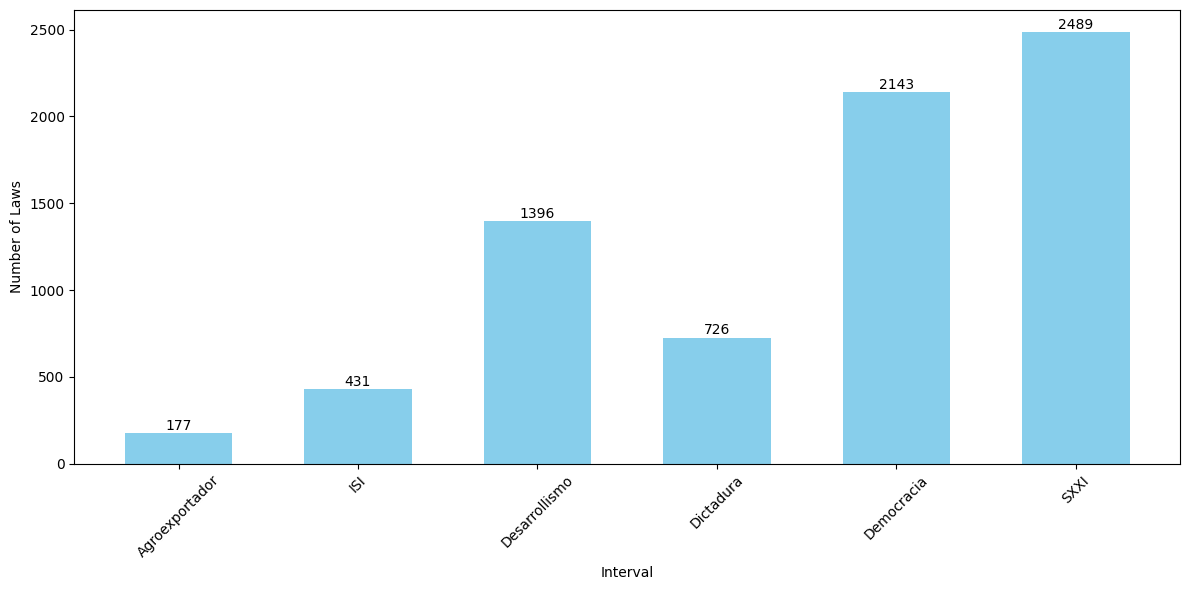

In [19]:
interval_labels = [get_interval(int(year), intervals=intervals) for _, year, _ in clean_data]
unique_intervals, counts = np.unique(interval_labels, return_counts=True)

ordered_intervals = list(intervals.keys()) 
ordered_counts = [counts[list(unique_intervals).index(interval)] if interval in unique_intervals else 0 for interval in ordered_intervals]

plt.figure(figsize=(12, 6))
plt.bar(ordered_intervals, ordered_counts, width=0.6, color='skyblue')
plt.xticks(rotation=45)

for i, count in enumerate(ordered_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.xlabel('Interval')
plt.ylabel('Number of Laws')

plt.tight_layout()
plt.savefig('./output/laws_by_interval.png')
plt.show()

In [20]:
laws_by_interval = defaultdict(list)
for law, year, words in clean_data:
    label = get_interval(year, intervals)
    laws_by_interval[label].append((law, year, words))

In [21]:
random.seed(111)
selected_laws = []
for decade, laws in laws_by_interval.items():
    selected_laws.extend(random.sample(laws, 170)) 

In [22]:
with open('./input/selected_laws_case_study.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(selected_laws)

In [23]:
csv.field_size_limit(10_000_000)
selected_laws = []
with open('./input/selected_laws_case_study.csv', 'r', encoding='utf-8', newline='') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        row[2] = ast.literal_eval(row[2])
        selected_laws.append(row)

In [24]:
top_words = {}
for label, interval in intervals.items():
    interval = [str(num) for num in interval]
    tfidf_vectors, vocab_index = tfidf(selected_laws, interval=interval)
    tfidf_vectors = pd.DataFrame(tfidf_vectors, index=vocab_index.keys())
    tfidf_vectors = tfidf_vectors[tfidf_vectors.index.str.len() > 4]
    
    top_words_per_year = {}
    for year in tfidf_vectors.columns:
        sorted_words = tfidf_vectors[year].sort_values(ascending=False)
        top = sorted_words.head(10)
        top_words_per_year[year] = top.index.tolist()
    
    top_words[f"{interval[0]}-{interval[-1]}"] = pd.DataFrame.from_dict(
        top_words_per_year, orient='index', 
        columns=[f"Top {i+1}" for i in range(10)]
    )
top_words = pd.concat(top_words, axis=0)
top_words.to_csv('./input/palabras_importantes_case.csv')

In [25]:
all_words = top_words.values.flatten()
all_words = [word for word in all_words if pd.notnull(word)]
word_counts = Counter(all_words)
ranking_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
ranking_df = ranking_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
ranking_df.to_csv('./input/palabras_mas_recurrentes_case.csv', index= False)

In [26]:
words_by_interval = defaultdict(list)
for label, interval in intervals.items():
    start_year = interval[0]
    end_year = interval[-1]
    
    for element in selected_laws:
        _, year, words = element 
        year = int(year)
        if start_year <= year <= end_year:
            words_by_interval[label].append(words)

In [27]:
for interval, words in tqdm.tqdm(words_by_interval.items()):
    globals()[f"model_{interval}"] = Word2Vec(words, vector_size= 300, window= 5, workers= 5) 

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


In [28]:
for interval, _ in tqdm.tqdm(words_by_interval.items()):
    model = globals()[f'model_{interval}']
    with tempfile.NamedTemporaryFile(prefix= f'gensim-model-{interval}', delete=False) as tmp:
        model.save(f'./word2vec_models/gensim-model-{interval}')

100%|██████████| 6/6 [00:00<00:00, 80.73it/s]


In [29]:
for label, interval in intervals.items():
    start = interval[0]
    end = interval[-1]
    model_file = os.path.join('./word2vec_models/', f'gensim-model-{label}')
    try:
        os.path.exists(model_file)
        globals()[f'model_{label}'] = gensim.models.Word2Vec.load(model_file)
    except Exception as e:
        print(e)

In [30]:
ranking_df = pd.read_csv('./input/palabras_mas_recurrentes_case.csv')
top_words = pd.read_csv('./input/palabras_importantes_case.csv')
top_words.columns = ['decada', 'año'] + list(top_words.columns[2:])

In [31]:
results = []
for word in ranking_df['Word']:
    years_found = top_words[top_words.iloc[:, 2:].isin([word]).any(axis=1)]['año'].tolist()
    results.append({'word': word, 'years': years_found})

words_years = pd.DataFrame(results)

models_to_use = defaultdict(set)
for _, row in words_years.head(5).iterrows():
    word = row.iloc[0]
    years = row.iloc[1]
    for interval in intervals:
        for year in years:
            if year in intervals[interval]:
                models_to_use[word].add(f'model_{interval}')
                
models_to_use = {word: list(models) for word, models in models_to_use.items()}

In [32]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_map = {}


def color_func(word, *args, **kwargs):
    return color_map.get(word, "black")

def plot_wordcloud(word, models_to_use, name, top_n=10):
    global color_map
    color_map = {}
    words_dict = {}
    legend_elements = []
    model_names = models_to_use[word]
    
    for idx, model_var in enumerate(model_names):
        try:
            model = globals()[model_var]
            if word not in model.wv:
                print(f"'{word}' not found in the vocabulary of model '{model_var}'. Skipping.")
                continue
            
            similar_words = model.wv.most_similar(word, topn=top_n)
            
            model_color = colors[idx % len(colors)]
            label = model_var.replace('model_', '')
            legend_elements.append(plt.Line2D([0], [0], color=model_color, lw=4, label=label))
            
            for sim_word, similarity in similar_words:
                if len(sim_word) > 4:
                    words_dict[sim_word] = max(words_dict.get(sim_word, 0), similarity * 100)
                    color_map[sim_word] = model_color
                else:
                    continue
                
        except KeyError:
            print(f"Model '{model_var}' not found in globals(). Skipping.")
    
    words_dict[word] = 150
    color_map[word] = "black"
    
    wc = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1.0)
    wc.generate_from_frequencies(words_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc.recolor(color_func=color_func, random_state=3), interpolation="bilinear")
    plt.axis("off")
    
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Models", fontsize=10)
    plt.subplots_adjust(right=0.85)
    plt.savefig(f'./output/wordcloud_{name}.png')
    plt.show()

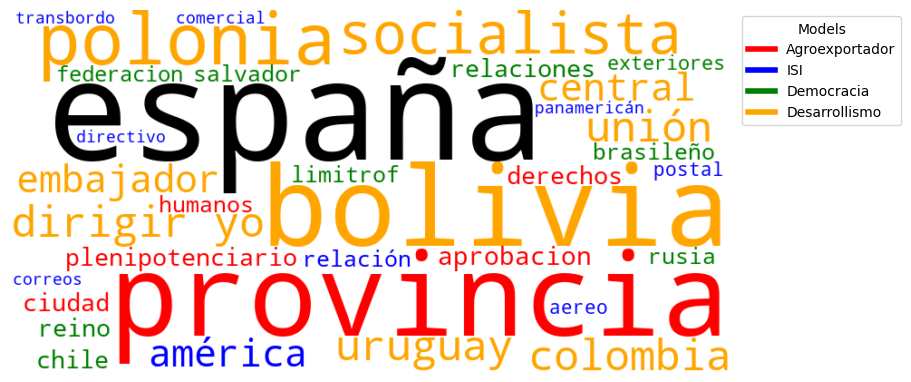

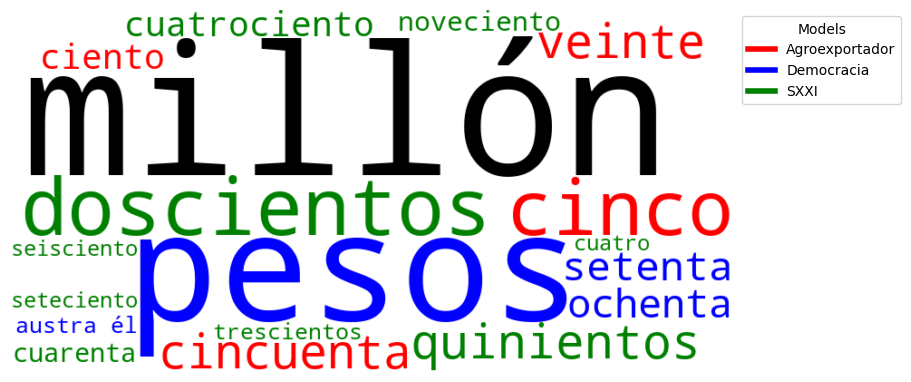

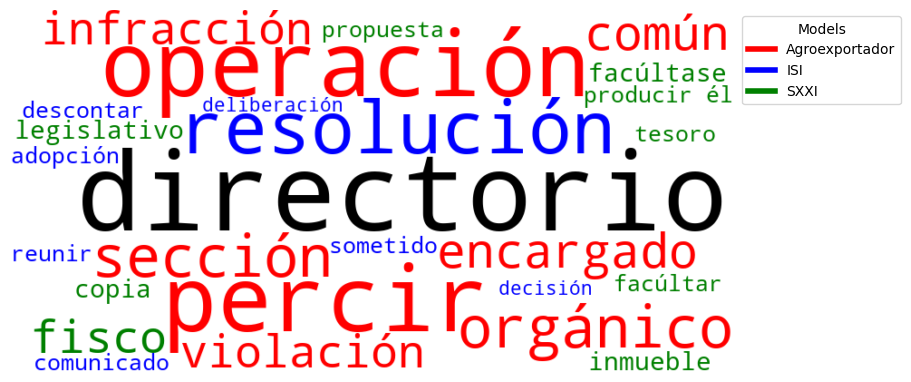

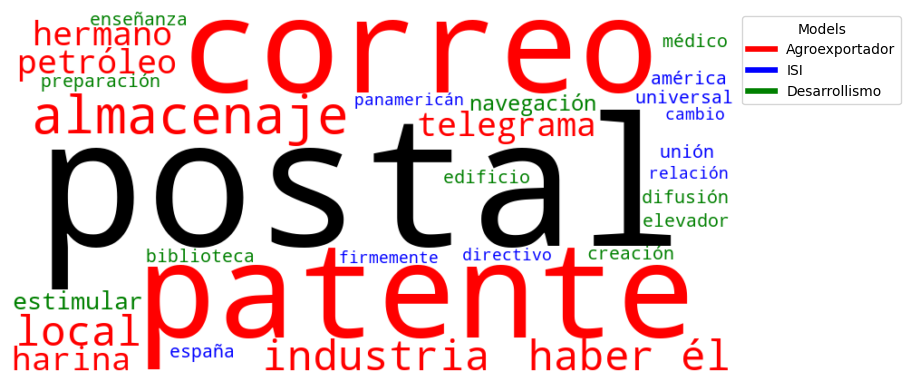

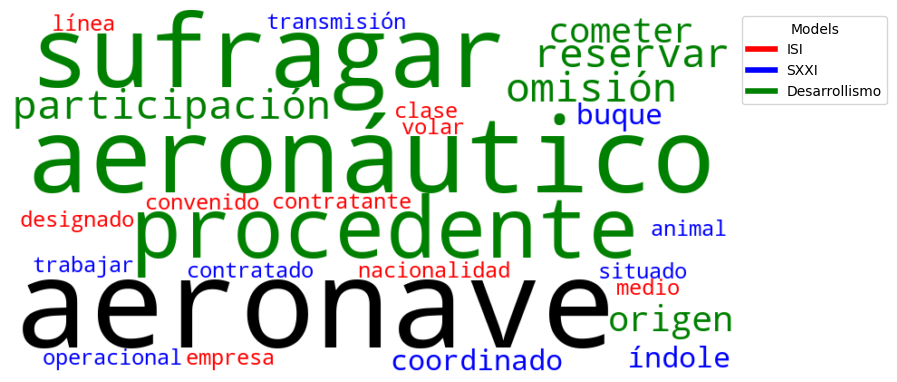

In [33]:
for word in models_to_use.keys():
    name = word + '_case'
    plot_wordcloud(word, models_to_use, name, 10)

In [34]:
models = []
for label in intervals.keys():
    models.append(f"model_{label}")

In [35]:
for model in models[1:]:
    model = globals()[model]
    mapping = get_mapping(model_Agroexportador, model)
    print(len(mapping))

213
202
205
209
206


In [36]:
top_words = pd.read_csv('./input/palabras_importantes_case.csv')
words = list(top_words.iloc[0:36, 2:].values.flatten())

In [37]:
proj = []
semantic_drift = []
for model_name in models[1:]:
    model = globals()[model_name]
    projected_words, drift_data = similar_words_df(model_Agroexportador, model, words= words)
    
    for entry in projected_words:
        proj.append({
            "target_model": model_name,
            "word": entry["word"],
            "similar_word": entry["similar_word"],
            "score": entry["score"]
        })
        
    for drift_entry in drift_data:
        semantic_drift.append({
            "target_model": model_name,
            "word": drift_entry["word"],
            "semantic_drift": drift_entry["semantic_drift"]
        })

proj = pd.DataFrame(proj)
semantic_drift = pd.DataFrame(semantic_drift)

In [38]:
max_words = semantic_drift.loc[semantic_drift.groupby('target_model')['semantic_drift'].idxmax(), 'word']
selected_words = max_words.unique()
filtered_data = semantic_drift[semantic_drift['word'].isin(selected_words)]

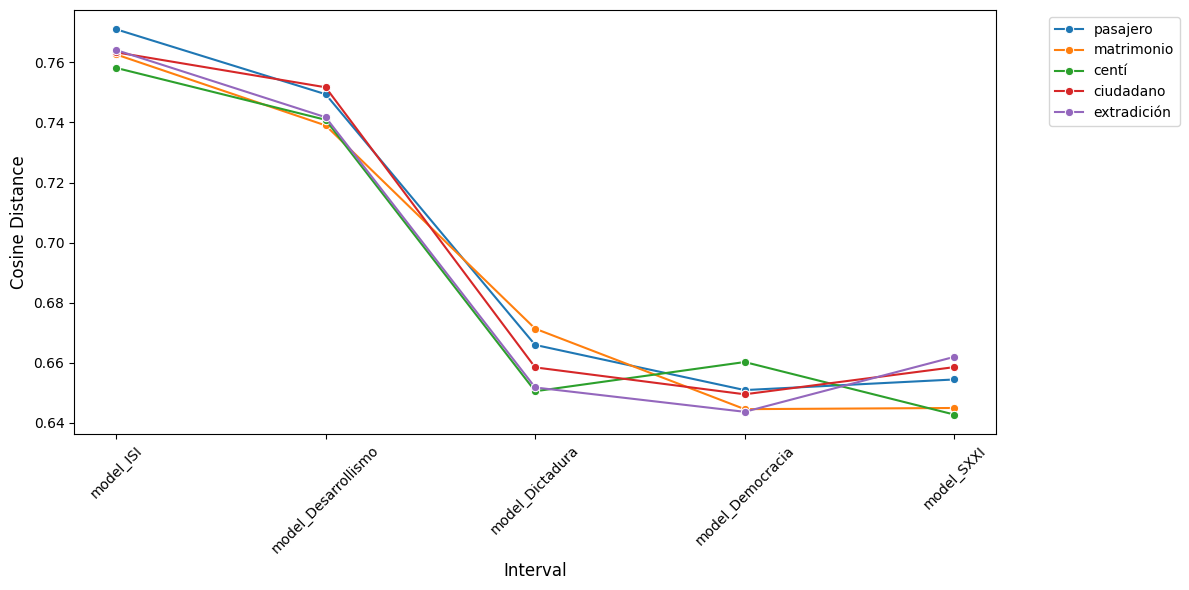

In [39]:
semantic_drift_time(filtered_data, 'maximos_case')

In [40]:
min_words = semantic_drift.loc[semantic_drift.groupby('target_model')['semantic_drift'].idxmin(), 'word']
selected_words = min_words.unique()
filtered_data = semantic_drift[semantic_drift['word'].isin(selected_words)]

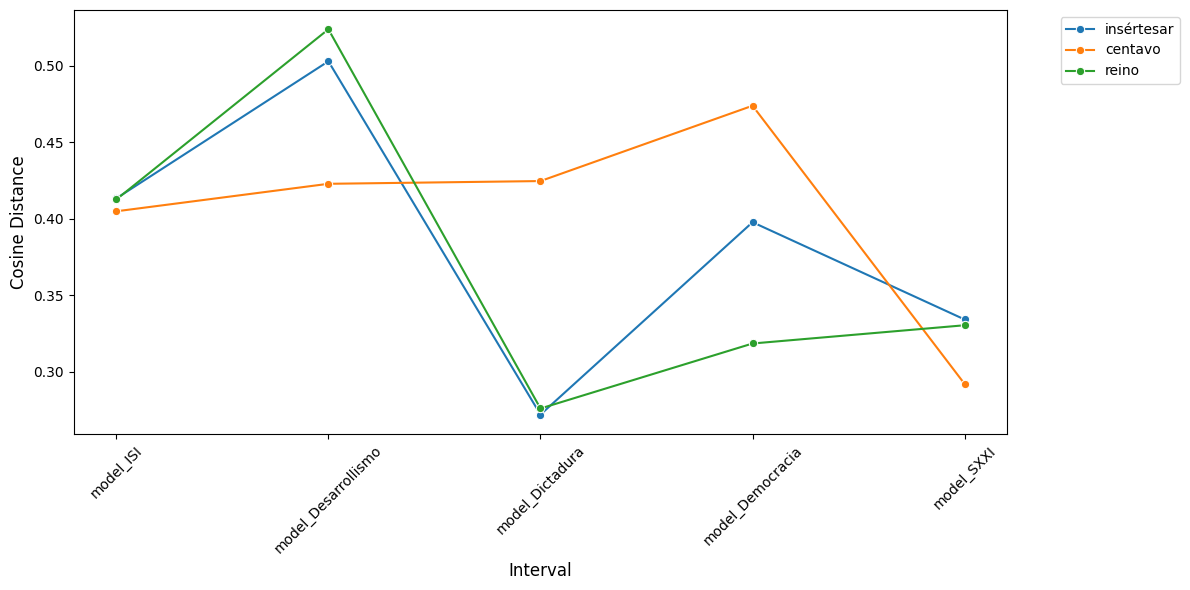

In [41]:
semantic_drift_time(filtered_data, 'minimos_case')

In [48]:
drift = defaultdict(lambda: defaultdict(float))
for word, models in models_to_use.items():
    if word in model_Agroexportador.wv:
        for model in models:
            if model != 'model_Agroexportador':
                modelo = globals()[model]
                f = projected_vector(model_Agroexportador, modelo, word)
                v = modelo.wv[word]
                distance = cosine(v, f)
                drift[word][model] = distance
                  
drift = pd.DataFrame(drift)

<Figure size 1200x600 with 0 Axes>

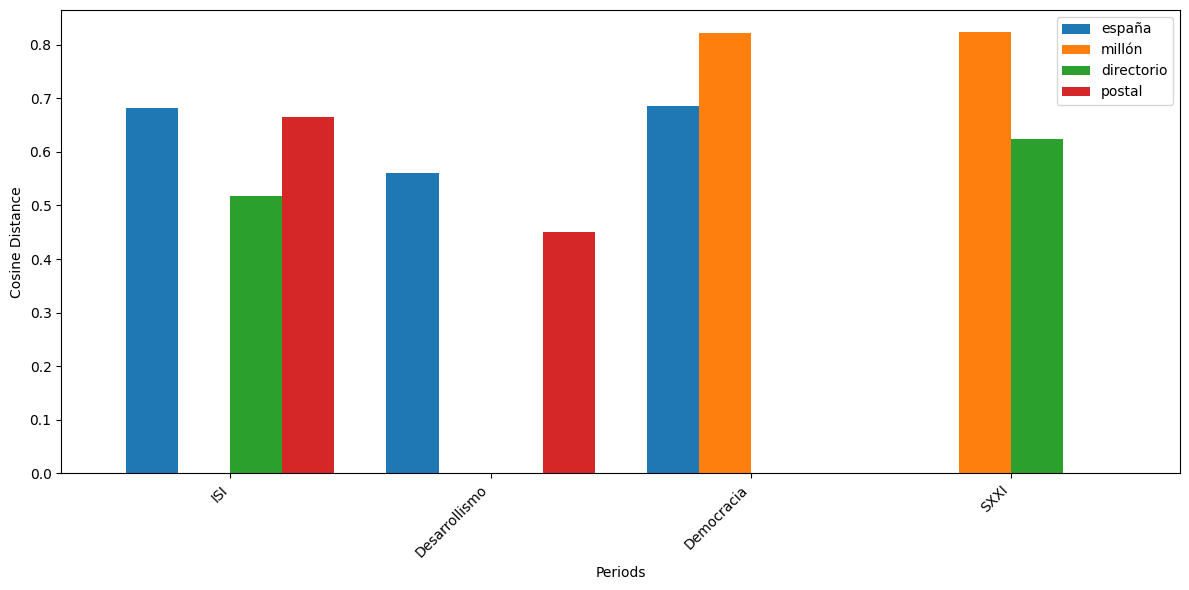

In [ ]:
drift['period'] = [get_period_from_model(model, intervals) for model in drift.index]
period_order = list(intervals.keys())
drift_sorted = drift.sort_values(by='period', key=lambda x: x.map(lambda p: period_order.index(p)))
plt.figure(figsize=(12, 6))
ax = drift_sorted.drop(columns='period').plot(kind='bar', figsize=(12, 6), width=0.8)
ax.set_xlabel('Periods')
ax.set_ylabel('Cosine Distance')
ax.set_xticks(range(len(drift_sorted.index)))
ax.set_xticklabels(drift_sorted['period'], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('./output/cosine_drift_periods.png')
plt.show()